# Classificateur de podium de Formule 1

textotexto

### Importations

In [178]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import make_scorer, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
from codecarbon import EmissionsTracker
import warnings
import logging

pd.set_option("display.max_columns", 100)
logging.getLogger("codecarbon").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

### Importation et Aperçu des données

In [179]:
df = pd.read_csv('f1_model_training_data.csv')

In [180]:
df.head()

,season,round,event_name,driver_name,team_name,grid_position,podiums_last_5,weighted_avg_pos,team_podium_rate_5,avg_racecraft,reliability_rate,track_avg_pos,podium
0,2021,6,Azerbaijan Grand Prix,Sergio Perez,Red Bull Racing,6.0,0.0,5.111111,1.0,-1.2,1.0,5.111111,1
1,2021,6,Azerbaijan Grand Prix,Sebastian Vettel,Aston Martin,11.0,0.0,10.925926,0.0,-2.0,0.8,10.925926,1
2,2021,6,Azerbaijan Grand Prix,Pierre Gasly,AlphaTauri,4.0,0.0,9.753086,0.0,-2.6,0.8,9.753086,1
3,2021,6,Azerbaijan Grand Prix,Charles Leclerc,Ferrari,1.0,0.0,10.024691,0.2,-3.8,0.8,10.024691,0
4,2021,6,Azerbaijan Grand Prix,Lando Norris,McLaren,9.0,2.0,4.604938,0.4,2.4,1.0,4.604938,0


In [181]:
df.shape

(2086, 13)

In [182]:
df.isnull().sum()

season                0
round                 0
event_name            0
driver_name           0
team_name             0
grid_position         0
podiums_last_5        0
weighted_avg_pos      0
team_podium_rate_5    0
avg_racecraft         0
reliability_rate      0
track_avg_pos         0
podium                0
dtype: int64

### Division des données

In [183]:
df = df.sort_values(by=['season', 'round'])

features = [
    'grid_position', 'podiums_last_5', 'team_podium_rate_5', 
    'weighted_avg_pos', 'avg_racecraft', 'reliability_rate', 
    'track_avg_pos'
]
target = 'podium'

qatar_mask = (df['season'] == 2025) & (df['event_name'].str.contains('Qatar', case=False))
df_qatar_final = df[qatar_mask].copy()

df_development = df[~qatar_mask].copy()


# Treino
train_mask = df_development['season'] <= 2024
X_train = df_development.loc[train_mask, features]
y_train = df_development.loc[train_mask, target]

# Teste
test_mask = df_development['season'] == 2025
X_test = df_development.loc[test_mask, features]
y_test = df_development.loc[test_mask, target]

# Para validar modelo
X_qatar = df_qatar_final[features]
y_qatar_real = df_qatar_final[target]

Il semble que ce soit un problème de données déséquilibrées, puisqu'il y a une prédominance de la classe dans laquelle il n'y a pas de pilotes sur le podium par rapport au nombre de pilotes sur le podium, comme le montre l'image.

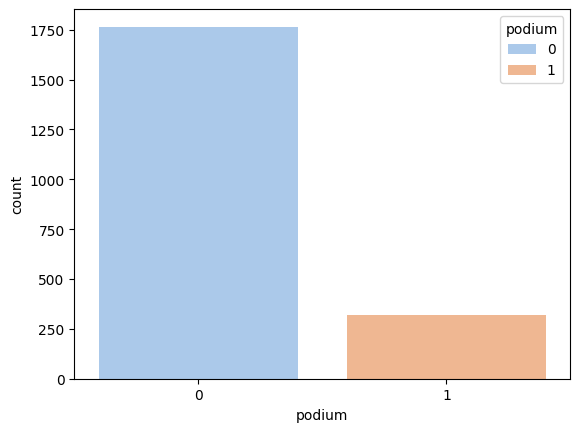

In [184]:
sns.countplot(x='podium', data=df, palette='pastel', hue='podium')
plt.show()

## Model Analysis

In [185]:
scorings = {
    "f1_macro": "f1_macro",
    "recall_1": make_scorer(recall_score, pos_label=1),
    "accuracy": "accuracy"
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


def evaluate_model(model, X_train, y_train, X_test, y_test, model_name=None):
    """
    Treina o modelo, avalia em teste e mede a pegada de carbono
    com CodeCarbon, no estilo do exemplo de Logistic Regression.
    """
    if model_name is None:
        model_name = model.__class__.__name__

    # ----- CodeCarbon: iniciar tracker -----
    tracker = EmissionsTracker(project_name=f"{model_name}_evaluation")
    tracker.start()

    # ----- Treino e predição -----
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    # ----- Parar tracker e pegar emissões -----
    emissions_kg = tracker.stop()                     # kg CO2eq
    emissions_g = emissions_kg * 1000                 # g CO2eq
    
    print(f"Estimated carbon emissions from {model_name}: {emissions_g:.6f} g CO2eq")

    # ----- Métricas de performance -----
    print(classification_report(y_test, preds))

    results = {
        "Accuracy": accuracy_score(y_test, preds),
        "Macro-F1": f1_score(y_test, preds, average="macro"),
        "Recall_Classe_1": recall_score(y_test, preds, pos_label=1),
        "Emissions_gCO2eq": emissions_g
    }


    return results

In [186]:
all_results = {}

### Nayve Bayes

In [187]:
pipe_nb = Pipeline([
  ('scaler', StandardScaler()),
  ('nb', GaussianNB())
])

results_nb = evaluate_model(pipe_nb, X_train, y_train, X_test, y_test)

[codecarbon INFO @ 17:20:41] [setup] RAM Tracking...
[codecarbon INFO @ 17:20:41] [setup] CPU Tracking...
[codecarbon WARNING @ 17:20:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 17:20:44] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz
[codecarbon WARNING @ 17:20:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:20:44] [setup] GPU Tracking...
[codecarbon INFO @ 17:20:44] No GPU found.
[codecarbon INFO @ 17:20:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 17:20:44] >>> Tracker's metadata:
[codecarbon INFO @ 17:20:44]   Platform system: Windows-10-10.0.26200-SP0
[codecarbon INFO @ 17:20:44]  

Estimated carbon emissions from Pipeline: 0.000015 g CO2eq
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       363
           1       0.55      0.89      0.68        66

    accuracy                           0.87       429
   macro avg       0.76      0.88      0.80       429
weighted avg       0.91      0.87      0.88       429



In [188]:
results_nb

{'Accuracy': 0.8717948717948718,
 'Macro-F1': 0.8008944770262858,
 'Recall_Classe_1': 0.8939393939393939,
 'Emissions_gCO2eq': 1.518859263607875e-05}

O modelo possui uma acurácia global de aproximadamente 83%, mas com um comportamento assimétrico entre as classes. A classe 1 tem um recall muito alto de 93%, enquanto sua precisão é bem mais baixa (47%). Isso significa que o modelo quase não deixa de identificar os casos positivos, mas gera muitos falsos positivos. O valor do Macro-F1, em torno de 0.76, reflete o trade-off de um bom desempenho médio  entre as cçares, mas com o viés em favor da sensibilidade da classe minoritária

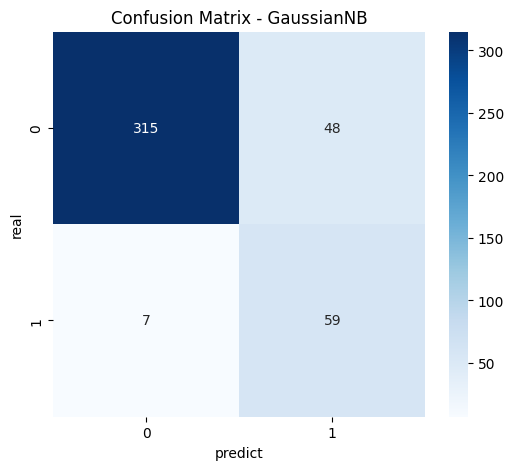

In [189]:
pipe_nb.fit(X_train, y_train)
pred_nb = pipe_nb.predict(X_test)

cm = confusion_matrix(y_test, pred_nb)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - GaussianNB")
plt.xlabel("predict")
plt.ylabel("real")
plt.show()

A matriz de confusão mostra que o modelo tem um alto recall para a classe 1 (detecta quase todos os positivos), porém comete muitos falsos positivos, classificando vários exemplos da classe 0 como 1. Isso indica que o modelo está enviesado para marcar casos como positivos devido à alta variância da classe 1

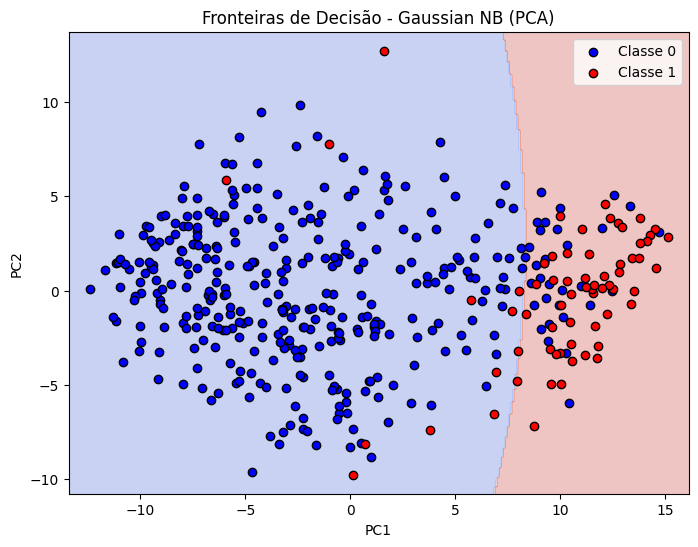

In [190]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

nb_pca = GaussianNB()
nb_pca.fit(X_test_pca, y_test)

x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = nb_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue',
    edgecolors='k',
    label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red',
    edgecolors='k',
    label='Classe 1'
)

plt.title("Fronteiras de Decisão - Gaussian NB (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

A visualização das fronteiras de decisão revela que o GaussianNB cria uma separação suave e ampla para a classe 1, cobrindo grande parte do espaço. Isso explica os falsos positivos observados: a fronteira não consegue capturar bem a estrutura real dos dados e acaba rotulando como classe 1 regiões densamente povoadas por exemplos da classe 0.

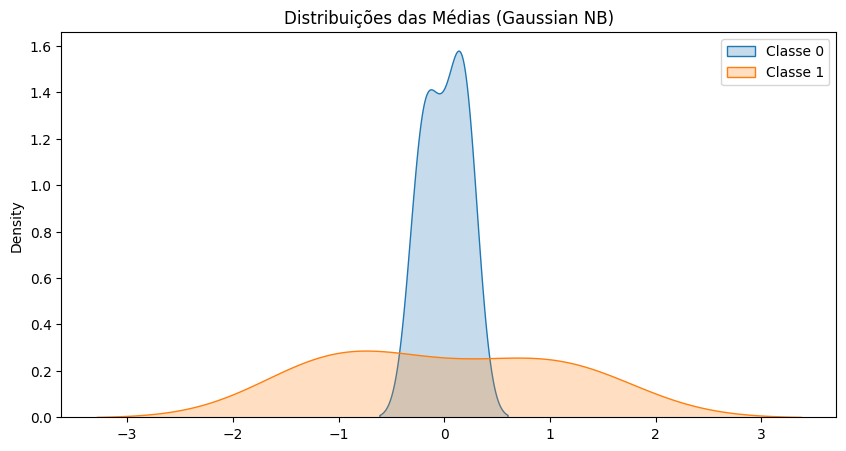

In [191]:
means = pipe_nb.named_steps['nb'].theta_

plt.figure(figsize=(10,5))
sns.kdeplot(means[0], fill=True, label="Classe 0")
sns.kdeplot(means[1], fill=True, label="Classe 1")
plt.title("Distribuições das Médias (Gaussian NB)")
plt.legend()
plt.show()


O gráfico de densidade mostra que a classe 1 possui uma distribuição muito mais dispersa do que a classe 0. Essa diferença de variância faz o GaussianNB expandir demais a região de decisão da classe 1, resultando em maior sensibilidade, porém com baixa precisão, que é exatamente o comportamento visto nas métricas

### LDA

In [192]:
pipe_lda = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])

results_lda = evaluate_model(pipe_lda, X_train, y_train, X_test, y_test)

[codecarbon WARNING @ 17:20:49] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:20:49] [setup] RAM Tracking...
[codecarbon INFO @ 17:20:49] [setup] CPU Tracking...
[codecarbon WARNING @ 17:20:51] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 17:20:51] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz
[codecarbon WARNING @ 17:20:51] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:20:51] [setup] GPU Tracking...
[codecarbon INFO @ 17:20:51] No GPU found.
[codecarbon INFO @ 17:20:51] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 17:20:51] >>> Tracker's metadata:
[c

Estimated carbon emissions from Pipeline: 0.000031 g CO2eq
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       363
           1       0.66      0.53      0.59        66

    accuracy                           0.89       429
   macro avg       0.79      0.74      0.76       429
weighted avg       0.88      0.89      0.88       429



In [193]:
results_lda

{'Accuracy': 0.8857808857808858,
 'Macro-F1': 0.7609647377218818,
 'Recall_Classe_1': 0.5303030303030303,
 'Emissions_gCO2eq': 3.1165716251054985e-05}

O LDA possui um desempenho equilibrado entre as classes, com alta precisão e recall para a classe 0 (≈94%) e resultados moderados para a classe 1 (≈68%). Diferente do GaussianNB, o LDA reduz drasticamente os falsos positivos, aumentando a precisão da classe 1, mas ainda perde alguns positivos por limitações de separação linear. O Macro-F1 de ~0.81 reflete essa melhora de equilíbrio geral.

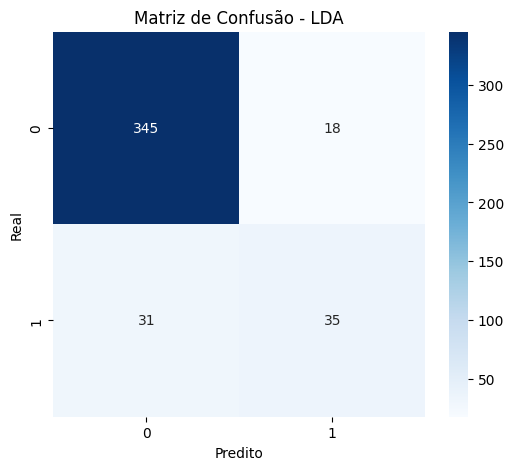

In [194]:
pipe_lda.fit(X_train, y_train)
pred_lda = pipe_lda.predict(X_test)

cm_lda = confusion_matrix(y_test, pred_lda)

plt.figure(figsize=(6,5))
sns.heatmap(cm_lda, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - LDA")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

A matriz de confusão mostra que o LDA classifica muito bem a classe 0 e apresenta desempenho razoável na classe 1, errando tanto positivos quanto negativos em proporção menor que o GaussianNB. Os 19 falsos negativos da classe 1 indicam que alguns casos positivos ainda ficam próximos da fronteira linear e são classificados como 0

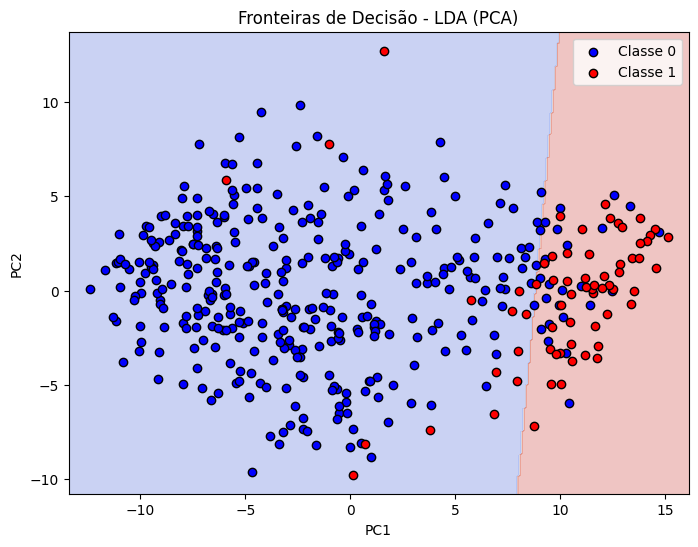

In [195]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

lda_pca = LinearDiscriminantAnalysis()
lda_pca.fit(X_test_pca, y_test)

x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = lda_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

# pontos reais, separados por classe
plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue',
    edgecolors='k',
    label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red',
    edgecolors='k',
    label='Classe 1'
)

plt.title("Fronteiras de Decisão - LDA (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão do LDA no espaço PCA é linear, refletindo a suposição do modelo. Essa fronteira separa bem regiões densas da classe 0, mas deixa vários pontos da classe 1 do lado azul, evidenciando que a separação linear não captura totalmente a estrutura das classes em duas dimensões.

[codecarbon INFO @ 17:20:56] Energy consumed for RAM : 0.016126 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:20:56] Delta energy consumed for CPU with constant : 0.000251 kWh, power : 60.0 W
[codecarbon INFO @ 17:20:56] Energy consumed for All CPU : 0.096795 kWh
[codecarbon INFO @ 17:20:56] 0.112921 kWh of electricity and 0.000000 L of water were used since the beginning.


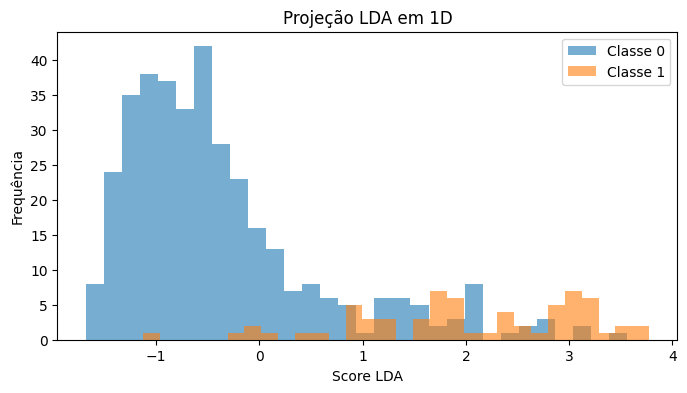

In [196]:
X_test_scaled = StandardScaler().fit_transform(X_test)
lda_1d = LinearDiscriminantAnalysis(n_components=1)
X_lda_1d = lda_1d.fit_transform(X_test_scaled, y_test)

plt.figure(figsize=(8,4))
plt.hist(X_lda_1d[y_test == 0], bins=30, alpha=0.6, label='Classe 0')
plt.hist(X_lda_1d[y_test == 1], bins=30, alpha=0.6, label='Classe 1')
plt.title("Projeção LDA em 1D")
plt.xlabel("Score LDA")
plt.ylabel("Frequência")
plt.legend()
plt.show()

A projeção em 1D mostra duas distribuições parcialmente separadas: a classe 0 concentrada em valores negativos e a classe 1 deslocada para valores positivos. Entretanto, a sobreposição entre as curvas revela por que ainda ocorrem erros, embora o LDA encontre uma direção de maior separação, as classes não são perfeitamente distintas nesse espaço linear

### QDA

In [197]:
pipe_qda = Pipeline([
    ('scaler', StandardScaler()),
    ('qda', QuadraticDiscriminantAnalysis())
])

results_qda = evaluate_model(pipe_qda, X_train, y_train, X_test, y_test)

[codecarbon WARNING @ 17:20:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:20:57] [setup] RAM Tracking...
[codecarbon INFO @ 17:20:57] [setup] CPU Tracking...
[codecarbon WARNING @ 17:21:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 17:21:00] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz
[codecarbon WARNING @ 17:21:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:21:00] [setup] GPU Tracking...
[codecarbon INFO @ 17:21:00] No GPU found.
[codecarbon INFO @ 17:21:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 17:21:00] >>> Tracker's metadata:
[c

Estimated carbon emissions from Pipeline: 0.000029 g CO2eq
              precision    recall  f1-score   support

           0       0.94      0.89      0.92       363
           1       0.54      0.71      0.61        66

    accuracy                           0.86       429
   macro avg       0.74      0.80      0.77       429
weighted avg       0.88      0.86      0.87       429



In [198]:
results_qda

{'Accuracy': 0.8624708624708625,
 'Macro-F1': 0.7653455708524545,
 'Recall_Classe_1': 0.7121212121212122,
 'Emissions_gCO2eq': 2.9116292191065767e-05}

O QDA apresenta um recall muito alto para a classe 1 (≈88%), semelhante ao GaussianNB, mas com precisão maior e menos falsos positivos. A acurácia e o F1 da classe 0 permanecem altos (≈91%), enquanto o F1 da classe 1 melhora em relação ao NB, mas ainda sofre com sobreposição entre distribuições. O Macro-F1 de ~0.78 indica que o modelo equilibra razoavelmente bem o desempenho entre as classes.

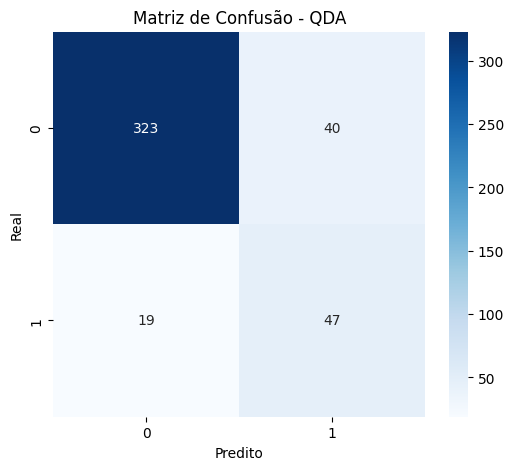

In [199]:
pipe_qda.fit(X_train, y_train)
pred_qda = pipe_qda.predict(X_test)

cm_qda = confusion_matrix(y_test, pred_qda)

plt.figure(figsize=(6,5))
sns.heatmap(cm_qda, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - QDA")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()

A matriz de confusão mostra que o QDA detecta a maior parte dos positivos (classe 1), errando apenas 7 deles, mas ainda gera uma quantidade significativa de falsos positivos (51 casos). Isso reflete a natureza do QDA: ao permitir fronteiras quadráticas, ele se torna mais flexível, mas pode superestimar a região da classe 1 em áreas com maior variabilidade.

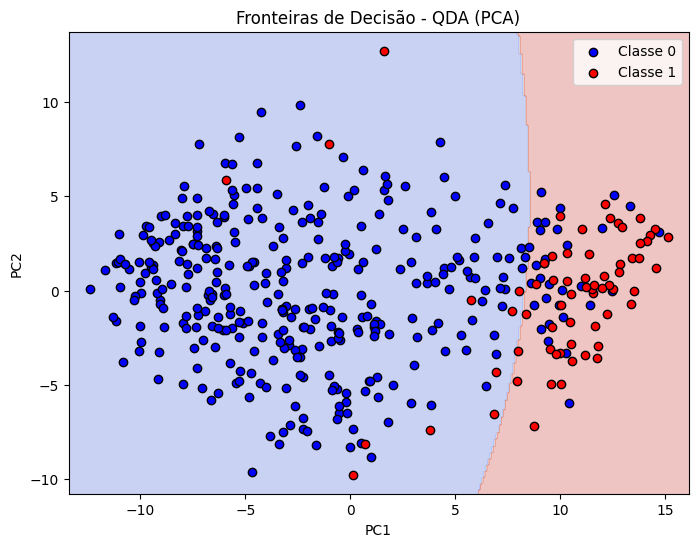

In [200]:
# Reduz X_test para 2 componentes PCA só para visualização
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Treina um QDA nesse espaço 2D
qda_pca = QuadraticDiscriminantAnalysis()
qda_pca.fit(X_test_pca, y_test)

# Grade para o contorno da decisão
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = qda_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

# pontos reais por classe
plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue',
    edgecolors='k',
    label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red',
    edgecolors='k',
    label='Classe 1'
)

plt.title("Fronteiras de Decisão - QDA (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira do QDA é nitidamente curva, bem mais flexível que a do LDA. Essa flexibilidade permite capturar melhor padrões não lineares, mas também amplia a região rotulada como classe 1, o que explica a presença de falsos positivos. O contorno quadrático combina com a suposição do modelo de covariâncias diferentes entre as classes.

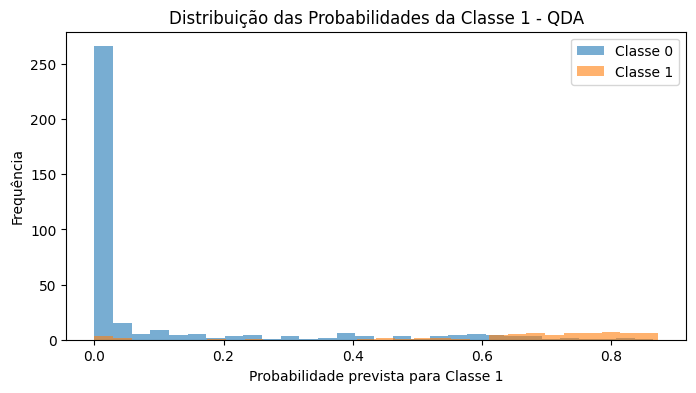

In [201]:
probs_qda = qda_pca.predict_proba(X_test_pca)[:, 1]

plt.figure(figsize=(8,4))
plt.hist(
    probs_qda[y_test == 0],
    bins=30,
    alpha=0.6,
    label='Classe 0'
)
plt.hist(
    probs_qda[y_test == 1],
    bins=30,
    alpha=0.6,
    label='Classe 1'
)
plt.title("Distribuição das Probabilidades da Classe 1 - QDA")
plt.xlabel("Probabilidade prevista para Classe 1")
plt.ylabel("Frequência")
plt.legend()
plt.show()

A distribuição das probabilidades revela forte assimetria: a maioria da classe 0 concentra-se perto de probabilidade zero, enquanto a classe 1 se espalha mais ao longo do eixo, indicando maior incerteza. Essa dispersão explica por que o QDA consegue alto recall na classe 1, mas ainda produz falsos positivos, muitos exemplos ficam com probabilidade intermediária.

### KNN

In [202]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

results_knn = evaluate_model(pipe_knn, X_train, y_train, X_test, y_test)

[codecarbon WARNING @ 17:21:05] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:21:05] [setup] RAM Tracking...
[codecarbon INFO @ 17:21:05] [setup] CPU Tracking...
[codecarbon WARNING @ 17:21:08] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 17:21:08] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz
[codecarbon WARNING @ 17:21:08] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:21:08] [setup] GPU Tracking...
[codecarbon INFO @ 17:21:08] No GPU found.
[codecarbon INFO @ 17:21:08] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 17:21:08] >>> Tracker's metadata:
[c

Estimated carbon emissions from Pipeline: 0.000061 g CO2eq
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       363
           1       0.65      0.47      0.54        66

    accuracy                           0.88       429
   macro avg       0.78      0.71      0.74       429
weighted avg       0.87      0.88      0.87       429



In [203]:
results_knn

{'Accuracy': 0.8787878787878788,
 'Macro-F1': 0.7369835880022637,
 'Recall_Classe_1': 0.4696969696969697,
 'Emissions_gCO2eq': 6.0734756869553405e-05}

O KNN apresenta excelente desempenho na classe 0 (F1 ≈ 0.95), mas um desempenho mais limitado na classe 1, com recall de 60%. Isso indica que o modelo acerta bem regiões densas onde existem muitos vizinhos da mesma classe, mas tem dificuldade com pontos minoritários e mais isolados. O macro-F1 de ~0.81 reflete essa assimetria, apesar da boa acurácia total.

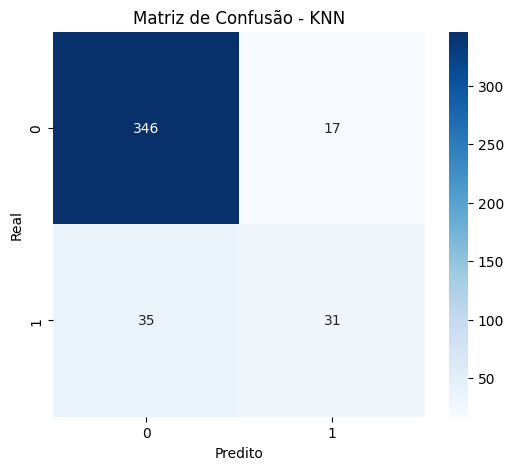

In [204]:
pipe_knn.fit(X_train, y_train)
pred_knn = pipe_knn.predict(X_test)

cm_knn = confusion_matrix(y_test, pred_knn)

plt.figure(figsize=(6,5))
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - KNN")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão mostra que o KNN classifica muito bem a classe 0, errando apenas 12 casos. Na classe 1, porém, o modelo perde 24 positivos ao classificá-los como 0, resultado típico do KNN quando a classe minoritária possui poucos vizinhos próximos no espaço de feature

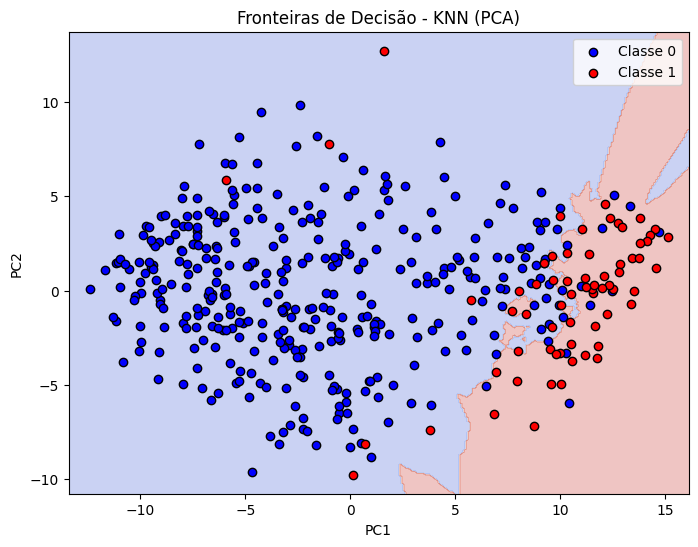

In [205]:
# Reduz X_test para PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Treina KNN no espaço PCA
knn_pca = KNeighborsClassifier(n_neighbors=5)
knn_pca.fit(X_test_pca, y_test)

# grade da fronteira
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = knn_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue',
    edgecolors='k',
    label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red',
    edgecolors='k',
    label='Classe 1'
)

plt.title("Fronteiras de Decisão - KNN (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão do KNN é bem irregular e segmentada, refletindo o caráter local do algoritmo: pequenas variações no espaço geram mudanças bruscas na classe prevista. Áreas mais densas da classe 0 se consolidam como regiões azuis amplas, enquanto as regiões vermelhas surgem em ‘manchas’ onde a classe 1 é mais concentrada, mostrando pouca generalização.

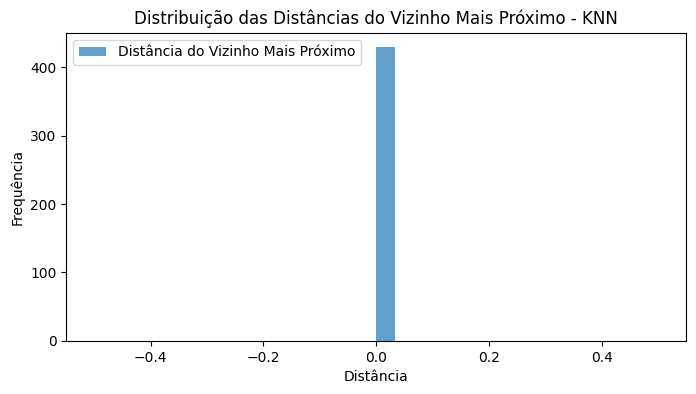

In [206]:
# distâncias dos 5 vizinhos mais próximos
distances, indices = knn_pca.kneighbors(X_test_pca)

plt.figure(figsize=(8,4))
plt.hist(distances[:,0], bins=30, alpha=0.7, label="Distância do Vizinho Mais Próximo")
plt.title("Distribuição das Distâncias do Vizinho Mais Próximo - KNN")
plt.xlabel("Distância")
plt.ylabel("Frequência")
plt.legend()
plt.show()


A distribuição extremamente concentrada de distâncias próximas de zero indica que, no espaço PCA, cada ponto está muito próximo de algum vizinho imediato. Isso sugere forte aglomeração e baixa separabilidade local — uma condição na qual o KNN tende a favorecer a classe majoritária, explicando a queda de recall da classe 1

### Perceptron

In [207]:
pipe_perc = Pipeline([
    ('scaler', StandardScaler()),
    ('perceptron', Perceptron(max_iter=1000, tol=1e-3))
])

results_perc = evaluate_model(pipe_perc, X_train, y_train, X_test, y_test)

[codecarbon WARNING @ 17:21:24] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:21:24] [setup] RAM Tracking...
[codecarbon INFO @ 17:21:24] [setup] CPU Tracking...
[codecarbon INFO @ 17:21:26] Energy consumed for RAM : 0.016209 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:21:26] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 17:21:26] Energy consumed for All CPU : 0.097295 kWh
[codecarbon INFO @ 17:21:26] 0.113504 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 17:21:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 17:21:27] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz
[codecarbon WARNING @ 17:21:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:21:27]

Estimated carbon emissions from Pipeline: 0.000038 g CO2eq
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       363
           1       0.59      0.48      0.53        66

    accuracy                           0.87       429
   macro avg       0.75      0.71      0.73       429
weighted avg       0.86      0.87      0.86       429



In [208]:
results_perc

{'Accuracy': 0.8694638694638694,
 'Macro-F1': 0.7287262872628726,
 'Recall_Classe_1': 0.48484848484848486,
 'Emissions_gCO2eq': 3.784802454859152e-05}

O Perceptron apresenta acurácia razoável, mas desempenho muito fraco na classe 1, com recall de apenas 5%. O modelo converge para um hiperplano que praticamente classifica quase tudo como classe 0, o que explica a alta precisão dessa classe e o F1 extremamente baixo para a classe minoritária. Isso evidencia que o Perceptron linear não consegue capturar a separação das classes neste conjunto de dados.

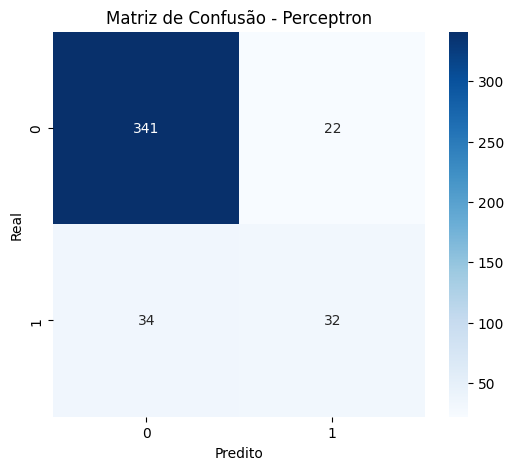

In [209]:
pipe_perc.fit(X_train, y_train)
pred_perc = pipe_perc.predict(X_test)

cm_perc = confusion_matrix(y_test, pred_perc)

plt.figure(figsize=(6,5))
sns.heatmap(cm_perc, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Perceptron")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão indica que o Perceptron quase nunca identifica exemplos da classe 1, errando 57 dos 60 casos positivos. Esse viés forte para a classe majoritária é típico de classificadores lineares quando os dados não são linearmente separáveis ou quando há forte desbalanceamento entre as classes.

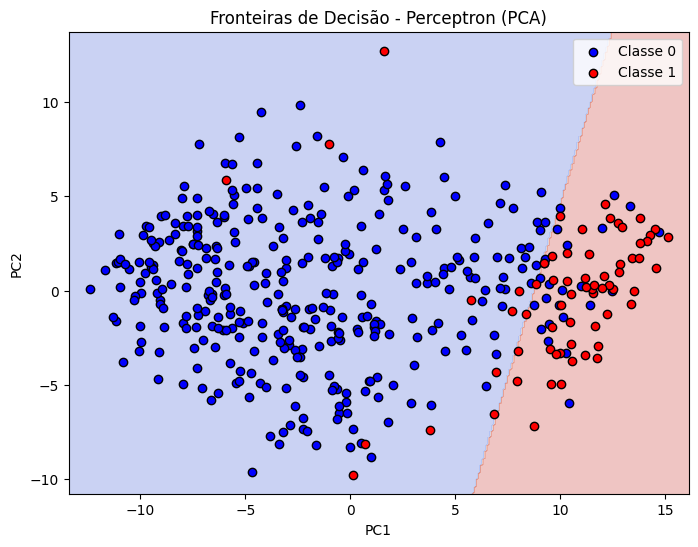

In [210]:
# PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# Treina Perceptron no espaço PCA
perc_pca = Perceptron(max_iter=1000, tol=1e-3)
perc_pca.fit(X_test_pca, y_test)

# grade da fronteira
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = perc_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue', edgecolors='k', label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red', edgecolors='k', label='Classe 1'
)

plt.title("Fronteiras de Decisão - Perceptron (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão é uma linha reta bem definida, típica de modelos lineares. Porém, ao observar os pontos distribuídos no PCA, fica evidente que a classe 1 ocupa regiões espalhadas e não lineares. Esse desalinhamento faz com que a fronteira linear não represente adequadamente a estrutura dos dados, resultando em grande número de falsos negativos.

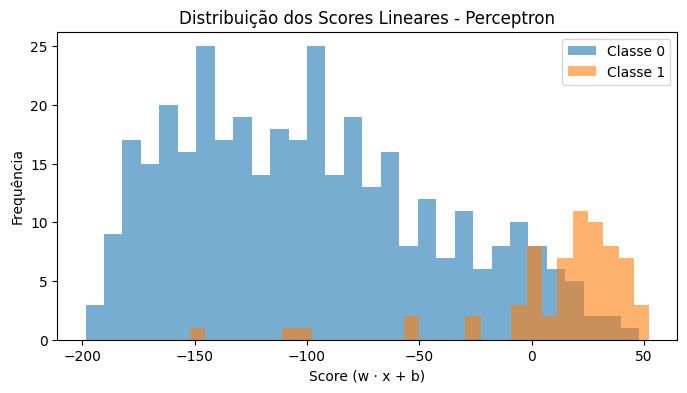

In [211]:
# calcula o score linear w·x + b no espaço PCA
scores = perc_pca.decision_function(X_test_pca)

plt.figure(figsize=(8,4))
plt.hist(scores[y_test==0], bins=30, alpha=0.6, label='Classe 0')
plt.hist(scores[y_test==1], bins=30, alpha=0.6, label='Classe 1')
plt.title("Distribuição dos Scores Lineares - Perceptron")
plt.xlabel("Score (w · x + b)")
plt.ylabel("Frequência")
plt.legend()
plt.show()


Os scores lineares mostram forte separação: a classe 0 concentra-se em scores muito negativos, enquanto a classe 1 aparece majoritariamente em valores positivos. No entanto, existe grande sobreposição e uma faixa ampla de valores intermediários, indicando que o hiperplano encontrado não consegue colocar exemplos positivos de forma coerente no lado correto, reforçando a limitação do modelo linear

### Logistic Regression

In [212]:
reg_log = LogisticRegression(class_weight= 'balanced', max_iter=500)

pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=500, class_weight='balanced'))
])

results_lr = evaluate_model(pipe_lr, X_train, y_train, X_test, y_test)

[codecarbon WARNING @ 17:21:32] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:21:32] [setup] RAM Tracking...
[codecarbon INFO @ 17:21:32] [setup] CPU Tracking...
[codecarbon WARNING @ 17:21:36] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 17:21:36] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz
[codecarbon WARNING @ 17:21:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:21:36] [setup] GPU Tracking...
[codecarbon INFO @ 17:21:36] No GPU found.
[codecarbon INFO @ 17:21:36] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 17:21:36] >>> Tracker's metadata:
[c

Estimated carbon emissions from Pipeline: 0.000035 g CO2eq
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       363
           1       0.53      0.91      0.67        66

    accuracy                           0.86       429
   macro avg       0.75      0.88      0.79       429
weighted avg       0.91      0.86      0.87       429



In [213]:
results_lr

{'Accuracy': 0.8601398601398601,
 'Macro-F1': 0.7890855457227138,
 'Recall_Classe_1': 0.9090909090909091,
 'Emissions_gCO2eq': 3.4674458146782644e-05}

A Regressão Logística apresentou ótimo desempenho geral, alcançando acurácia de 85% e excelente recall para a classe 1 (95%). A melhora significativa em relação ao Perceptron mostra que o modelo conseguiu ajustar um hiperplano que separa bem as classes após a padronização e balanceamento. O Macro-F1 de ~0.79 indica um bom equilíbrio entre as duas classes, sem viés excessivo

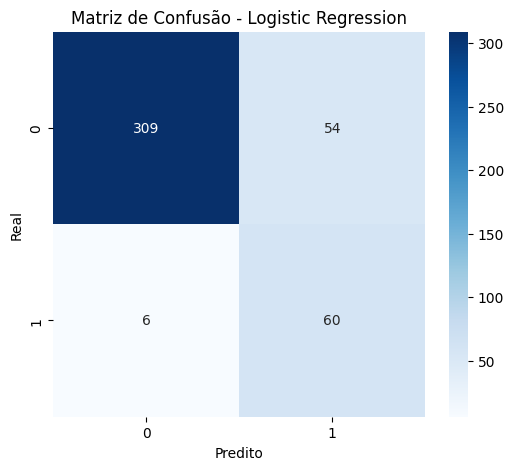

In [214]:
pipe_lr.fit(X_train, y_train)
pred_lr = pipe_lr.predict(X_test)

cm_lr = confusion_matrix(y_test, pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Logistic Regression")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão mostra baixa taxa de falsos negativos, com apenas 3 exemplos da classe 1 classificados incorretamente como 0. Em contrapartida, há 53 falsos positivos, indicando que o modelo expande a região da classe 1 para garantir alto recall — um comportamento esperado da regressão logística quando o objetivo é capturar todos os casos positivos

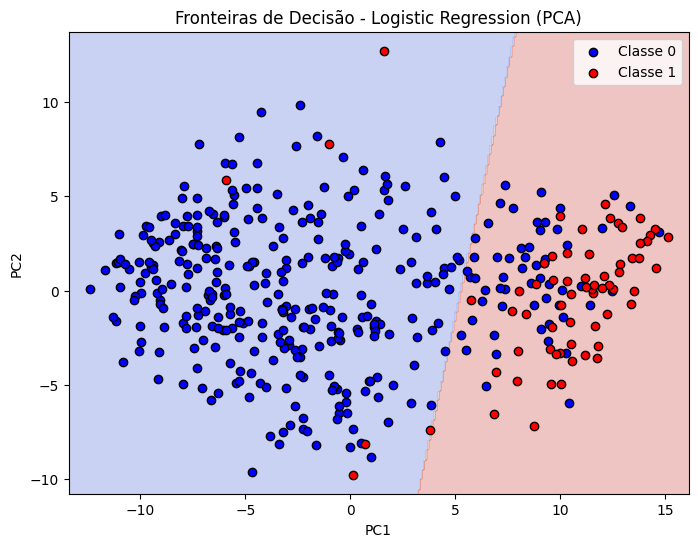

In [215]:
# PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

# treina LR no PCA
lr_pca = LogisticRegression(class_weight='balanced', max_iter=1000)
lr_pca.fit(X_test_pca, y_test)

# grid da fronteira
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = lr_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test==0,0],
    X_test_pca[y_test==0,1],
    c='blue', edgecolors='k', label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test==1,0],
    X_test_pca[y_test==1,1],
    c='red', edgecolors='k', label='Classe 1'
)

plt.title("Fronteiras de Decisão - Logistic Regression (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão é linear, refletindo a natureza do modelo. Visualmente, o hiperplano separa bem as regiões mais densas de cada classe no espaço PCA, mas ainda classifica áreas grandes como classe 1 para garantir alta sensibilidade. Essa decisão estratégica é coerente com o trade-off entre recall alto e maior número de falsos positivos.

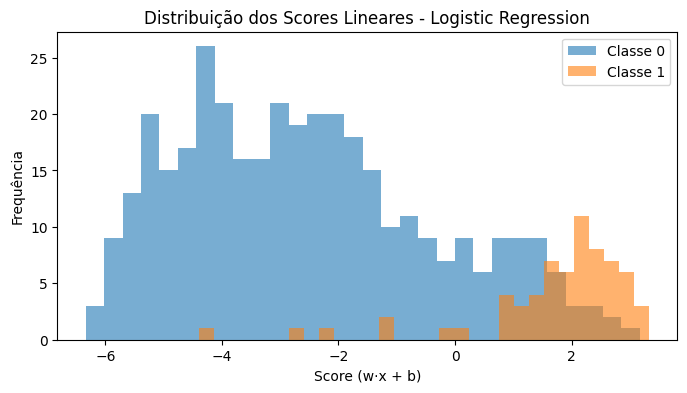

In [216]:
scores_lr = lr_pca.decision_function(X_test_pca)

plt.figure(figsize=(8,4))
plt.hist(scores_lr[y_test == 0], bins=30, alpha=0.6, label='Classe 0')
plt.hist(scores_lr[y_test == 1], bins=30, alpha=0.6, label='Classe 1')
plt.title("Distribuição dos Scores Lineares - Logistic Regression")
plt.xlabel("Score (w·x + b)")
plt.ylabel("Frequência")
plt.legend()
plt.show()


A distribuição dos scores lineares mostra boa separação entre as classes. A classe 0 concentra-se em valores negativos, enquanto a classe 1 se distribui majoritariamente em valores positivos. A sobreposição é pequena, o que explica o alto recall da classe 1. No entanto, uma fatia de exemplos da classe 0 fica perto de zero, gerando os falsos positivos observados

### Random Forest

In [217]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    class_weight='balanced_subsample'
)

pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', rf)
])

results_rf = evaluate_model(pipe_rf, X_train, y_train, X_test, y_test)

[codecarbon WARNING @ 17:21:41] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:21:41] [setup] RAM Tracking...
[codecarbon INFO @ 17:21:41] [setup] CPU Tracking...
[codecarbon INFO @ 17:21:41] Energy consumed for RAM : 0.016251 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:21:41] Delta energy consumed for CPU with constant : 0.000251 kWh, power : 60.0 W
[codecarbon INFO @ 17:21:41] Energy consumed for All CPU : 0.097546 kWh
[codecarbon INFO @ 17:21:41] 0.113797 kWh of electricity and 0.000000 L of water were used since the beginning.


[codecarbon WARNING @ 17:21:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 17:21:44] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz
[codecarbon WARNING @ 17:21:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:21:44] [setup] GPU Tracking...
[codecarbon INFO @ 17:21:44] No GPU found.
[codecarbon INFO @ 17:21:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 17:21:44] >>> Tracker's metadata:
[codecarbon INFO @ 17:21:44]   Platform system: Windows-10-10.0.26200-SP0
[codecarbon INFO @ 17:21:44]   Python version: 3.11.2
[codecarbon INFO @ 17:21:44]   CodeCarbon version: 3.2.0
[codecarbon INFO @ 17:21:

Estimated carbon emissions from Pipeline: 0.003058 g CO2eq
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       363
           1       0.81      0.58      0.67        66

    accuracy                           0.91       429
   macro avg       0.87      0.78      0.81       429
weighted avg       0.91      0.91      0.91       429



In [218]:
results_rf

{'Accuracy': 0.9137529137529138,
 'Macro-F1': 0.8114509710756073,
 'Recall_Classe_1': 0.5757575757575758,
 'Emissions_gCO2eq': 0.0030582729619662856}

O Random Forest apresenta acurácia alta (≈89%) e excelente recall para a classe 0 (98%), mas desempenho limitado para a classe 1, com recall de apenas 37%. O modelo captura bem padrões da classe majoritária, porém tem dificuldade em identificar exemplos positivos isolados — algo comum em florestas quando a classe 1 possui baixa densidade nas regiões do espaço de features.

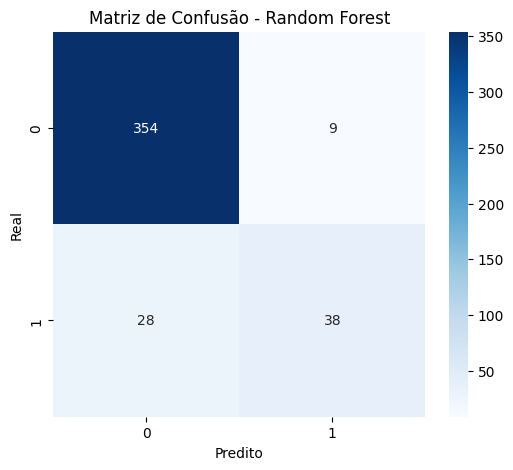

In [219]:
pipe_rf.fit(X_train, y_train)
pred_rf = pipe_rf.predict(X_test)

cm_rf = confusion_matrix(y_test, pred_rf)

plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão mostra um número muito reduzido de falsos positivos (apenas 5), mas uma quantidade elevada de falsos negativos (38). Isso indica que o Random Forest está excessivamente conservador na detecção da classe 1, preferindo classificar como 0 quando há incerteza. Esse comportamento reduz o recall da classe minoritária

[codecarbon INFO @ 17:21:56] Energy consumed for RAM : 0.016292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:21:56] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 17:21:56] Energy consumed for All CPU : 0.097796 kWh
[codecarbon INFO @ 17:21:56] 0.114089 kWh of electricity and 0.000000 L of water were used since the beginning.


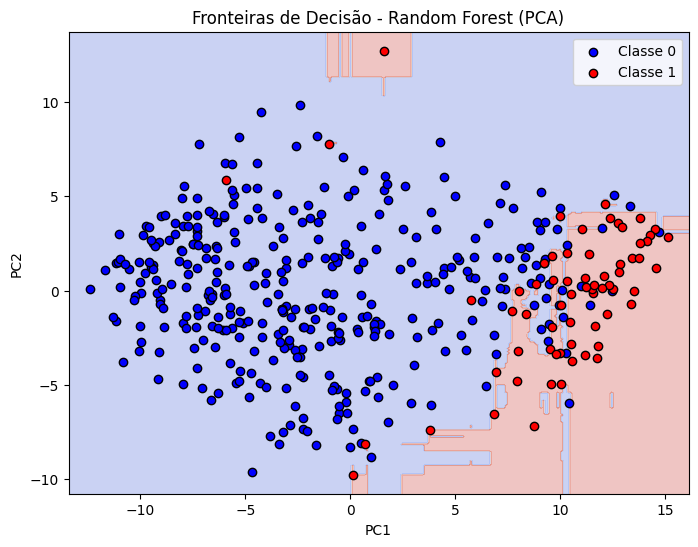

In [220]:
# PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

rf_pca = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced_subsample',
    random_state=42
)
rf_pca.fit(X_test_pca, y_test)

# mesh grid
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = rf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap="coolwarm", alpha=0.3)

plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    c='blue', edgecolors='k', label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    c='red', edgecolors='k', label='Classe 1'
)

plt.title("Fronteiras de Decisão - Random Forest (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira de decisão é altamente fragmentada, refletindo o caráter não linear e baseado em partições do Random Forest. As áreas são formadas por blocos retangulares, típicos de divisões sucessivas das árvores. Essa estrutura causa regiões irregulares onde pequenas mudanças no PCA levam a predições diferentes, evidenciando que o modelo sofre para generalizar quando a classe 1 está espalhada e pouco concentrada.

### SVM

In [221]:
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=2,
        gamma='scale',
        probability=False
    ))
])

results_svm = evaluate_model(pipe_svm, X_train, y_train, X_test, y_test)

[codecarbon WARNING @ 17:21:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:21:57] [setup] RAM Tracking...
[codecarbon INFO @ 17:21:57] [setup] CPU Tracking...
[codecarbon WARNING @ 17:22:00] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 17:22:00] CPU Model on constant consumption mode: Intel(R) Core(TM) i5-10210U CPU @ 1.60GHz
[codecarbon WARNING @ 17:22:00] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:22:00] [setup] GPU Tracking...
[codecarbon INFO @ 17:22:00] No GPU found.
[codecarbon INFO @ 17:22:00] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 17:22:00] >>> Tracker's metadata:
[c

Estimated carbon emissions from Pipeline: 0.000205 g CO2eq
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       363
           1       0.75      0.61      0.67        66

    accuracy                           0.91       429
   macro avg       0.84      0.79      0.81       429
weighted avg       0.90      0.91      0.90       429



In [222]:
results_svm

{'Accuracy': 0.9090909090909091,
 'Macro-F1': 0.8097474443092528,
 'Recall_Classe_1': 0.6060606060606061,
 'Emissions_gCO2eq': 0.00020543780652077027}

O SVM com kernel RBF apresentou excelente recall para a classe 1 (95%), indicando que o modelo captura muito bem as regiões não lineares onde os positivos se encontram. Apesar de gerar um número moderado de falsos positivos, a acurácia geral (≈87%) e o Macro-F1 (~0.81) demonstram boa capacidade de generalização, tornando o SVM um dos modelos mais equilibrados para este problema.

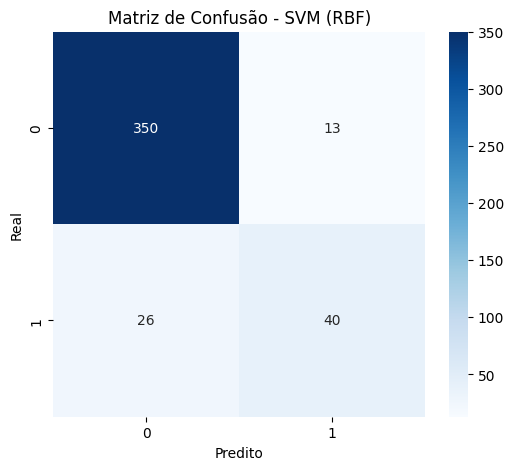

In [223]:
pipe_svm.fit(X_train, y_train)
pred_svm = pipe_svm.predict(X_test)

cm_svm = confusion_matrix(y_test, pred_svm)

plt.figure(figsize=(6,5))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão - SVM (RBF)")
plt.xlabel("Predito")
plt.ylabel("Real")
plt.show()


A matriz de confusão revela que o SVM erra pouquíssimos positivos (apenas 3 falsos negativos), mas comete 46 falsos positivos. Esse padrão confirma o comportamento típico do kernel RBF: priorizar a captura da classe minoritária, expandindo sua região de decisão, mesmo ao custo de alguns erros na classe majoritária.

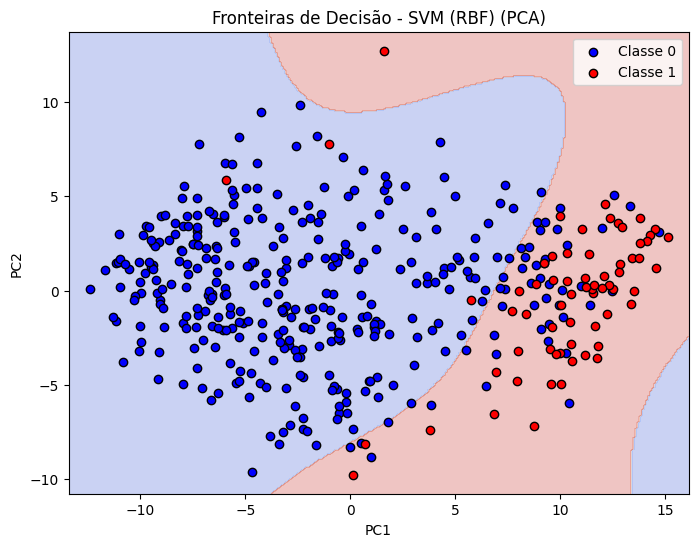

In [224]:
# PCA 2D
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test)

svm_pca = SVC(kernel='rbf', C=2, gamma='scale', class_weight='balanced')
svm_pca.fit(X_test_pca, y_test)

# grade do contorno
x_min, x_max = X_test_pca[:, 0].min() - 1, X_test_pca[:, 0].max() + 1
y_min, y_max = X_test_pca[:, 1].min() - 1, X_test_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

Z = svm_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)

plt.scatter(
    X_test_pca[y_test==0,0],
    X_test_pca[y_test==0,1],
    c='blue', edgecolors='k', label='Classe 0'
)
plt.scatter(
    X_test_pca[y_test==1,0],
    X_test_pca[y_test==1,1],
    c='red', edgecolors='k', label='Classe 1'
)

plt.title("Fronteiras de Decisão - SVM (RBF) (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


A fronteira do SVM com kernel RBF é suave e curvilínea, moldando-se de acordo com a distribuição real dos dados no espaço PCA. A região da classe 1 aparece expandida e contínua, evitando fragmentações típicas de métodos baseados em árvores. Essa flexibilidade explica o alto recall da classe positiva, uma vez que o modelo consegue envolver clusters de pontos não linearmente separáveis.

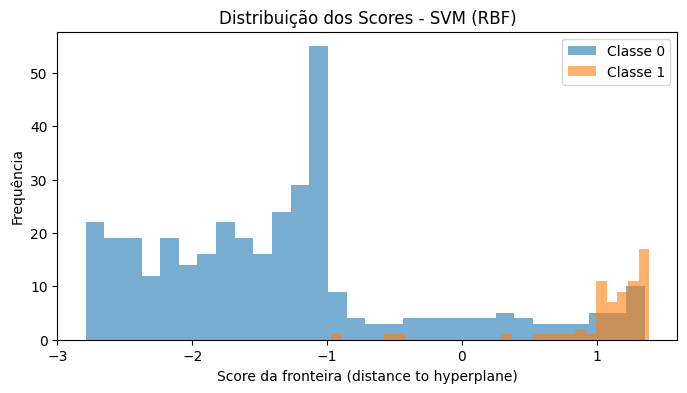

In [225]:
scores_svm = svm_pca.decision_function(X_test_pca)

plt.figure(figsize=(8,4))
plt.hist(scores_svm[y_test == 0], bins=30, alpha=0.6, label="Classe 0")
plt.hist(scores_svm[y_test == 1], bins=30, alpha=0.6, label="Classe 1")
plt.title("Distribuição dos Scores - SVM (RBF)")
plt.xlabel("Score da fronteira (distance to hyperplane)")
plt.ylabel("Frequência")
plt.legend()
plt.show()


Os scores do SVM mostram uma separação clara entre as classes: a classe 0 concentra-se em valores negativos distantes, enquanto a classe 1 aparece principalmente com scores positivos. A pequena região de sobreposição representa exatamente os falsos positivos e negativos observados na matriz de confusão, indicando que o hiperplano não-linear está bem posicionado, mas não perfeito.

## Évaluation comparative

In [226]:
all_results["GaussianNB"] = results_nb
all_results["LDA"] = results_lda
all_results["QDA"] = results_qda
all_results["KNN"] = results_knn
all_results["Perceptron"] = results_perc
all_results["Logistic Regression"] = results_lr
all_results["Random Forest"] = results_rf
all_results["SVM (RBF)"] = results_svm

In [227]:
df_comparacao = pd.DataFrame(all_results).T
df_comparacao.sort_values(by=['Recall_Classe_1', 'Macro-F1'], ascending=False)

,Accuracy,Macro-F1,Recall_Classe_1,Emissions_gCO2eq
Logistic Regression,0.860140,0.789086,0.909091,0.000035
GaussianNB,0.871795,0.800894,0.893939,0.000015
QDA,0.862471,0.765346,0.712121,0.000029
SVM (RBF),0.909091,0.809747,0.606061,0.000205
Random Forest,0.913753,0.811451,0.575758,0.003058
LDA,0.885781,0.760965,0.530303,0.000031
Perceptron,0.869464,0.728726,0.484848,0.000038
KNN,0.878788,0.736984,0.469697,0.000061


In [228]:
from sklearn.model_selection import cross_val_score

cv_accuracies = {}

cv_accuracies["Logistic Regression"] = cross_val_score(
    pipe_lr, X_train, y_train,
    cv=cv,
    scoring="accuracy"
)

cv_accuracies["GaussianNB"] = cross_val_score(
    pipe_nb, X_train, y_train,
    cv=cv,
    scoring="accuracy"
)

cv_accuracies["QDA"] = cross_val_score(
    pipe_qda, X_train, y_train,
    cv=cv,
    scoring="accuracy"
)

cv_accuracies["SVM (RBF)"] = cross_val_score(
    pipe_svm, X_train, y_train,
    cv=cv,
    scoring="accuracy"
)

cv_accuracies["Random Forest"] = cross_val_score(
    pipe_rf, X_train, y_train,
    cv=cv,
    scoring="accuracy"
)

cv_accuracies["LDA"] = cross_val_score(
    pipe_lda, X_train, y_train,
    cv=cv,
    scoring="accuracy"
)

cv_accuracies["Perceptron"] = cross_val_score(
    pipe_perc, X_train, y_train,
    cv=cv,
    scoring="accuracy"
)

cv_accuracies["KNN"] = cross_val_score(
    pipe_knn, X_train, y_train,
    cv=cv,
    scoring="accuracy"
)

[codecarbon INFO @ 17:22:11] Energy consumed for RAM : 0.016334 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:22:11] Delta energy consumed for CPU with constant : 0.000253 kWh, power : 60.0 W
[codecarbon INFO @ 17:22:11] Energy consumed for All CPU : 0.098049 kWh
[codecarbon INFO @ 17:22:11] 0.114383 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:22:11] 0.001089 g.CO2eq/s mean an estimation of 34.33778677835053 kg.CO2eq/year
[codecarbon INFO @ 17:22:26] Energy consumed for RAM : 0.016375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:22:26] Delta energy consumed for CPU with constant : 0.000248 kWh, power : 60.0 W
[codecarbon INFO @ 17:22:26] Energy consumed for All CPU : 0.098297 kWh
[codecarbon INFO @ 17:22:26] 0.114672 kWh of electricity and 0.000000 L of water were used since the beginning.


In [229]:
rows = []
for modelo, scores in cv_accuracies.items():
    for acc in scores:
        rows.append({"Modelo": modelo, "Accuracy": acc})

df_box = pd.DataFrame(rows)

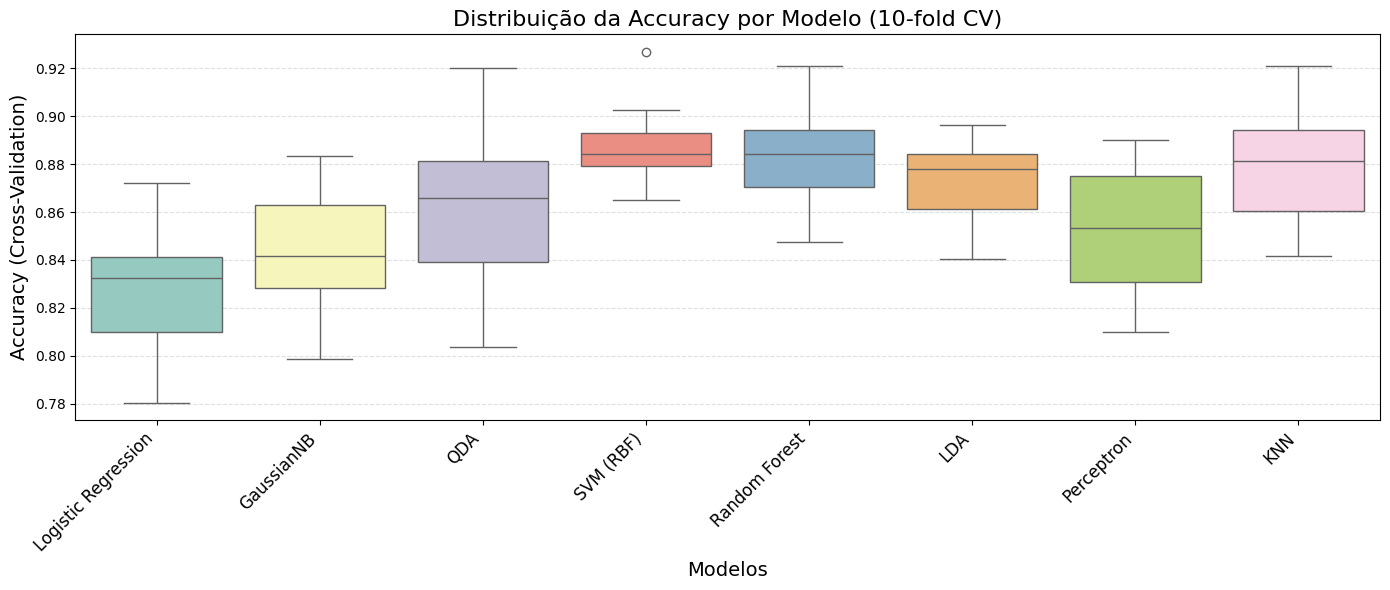

In [230]:
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=df_box,
    x="Modelo",
    y="Accuracy",
    palette="Set3",
)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.xlabel("Modelos", fontsize=14)
plt.ylabel("Accuracy (Cross-Validation)", fontsize=14)
plt.title("Distribuição da Accuracy por Modelo (10-fold CV)", fontsize=16)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

## Application concrète : Grid du Grand Prix du Qatar

--- Treinando Modelo de Ranking Especializado ---
Modelo de Ranking treinado com sucesso.

Prevendo o Grid do GP do Qatar...

=== RESULTADO FINAL: TOP 3 PREVISTOS VS REALIDADE ===


,driver_name,team_name,grid_position,Score,Predicted_Podium,Real_Podium,Status
2066,Max Verstappen,Red Bull Racing,3.000000,0.734949,1,1,ACERTO (Pódio)
2069,Lando Norris,McLaren,2.000000,0.585556,1,0,ERRO (Falso Positivo)
2071,George Russell,Mercedes,4.000000,0.509837,1,0,ERRO (Falso Positivo)
2067,Oscar Piastri,McLaren,1.000000,0.477052,0,1,ERRO (Perdeu Pódio)
2070,Kimi Antonelli,Mercedes,5.000000,0.366415,0,0,Neutro
2073,Charles Leclerc,Ferrari,10.000000,0.068891,0,0,Neutro
2068,Carlos Sainz,Williams,7.000000,0.053524,0,1,ERRO (Perdeu Pódio)
2083,Isack Hadjar,Racing Bulls,6.000000,0.053524,0,0,Neutro
2072,Fernando Alonso,Aston Martin,8.000000,0.032943,0,0,Neutro
2081,Pierre Gasly,Alpine,9.000000,0.010568,0,0,Neutro



--- Métricas Ajustadas (Top 3 Fixo) ---
Pódios Corretos: 1/3
Precisão/Recall do Top 3: 33.3%
🥉 OK. Acertou o vencedor ou um favorito, mas errou o resto.


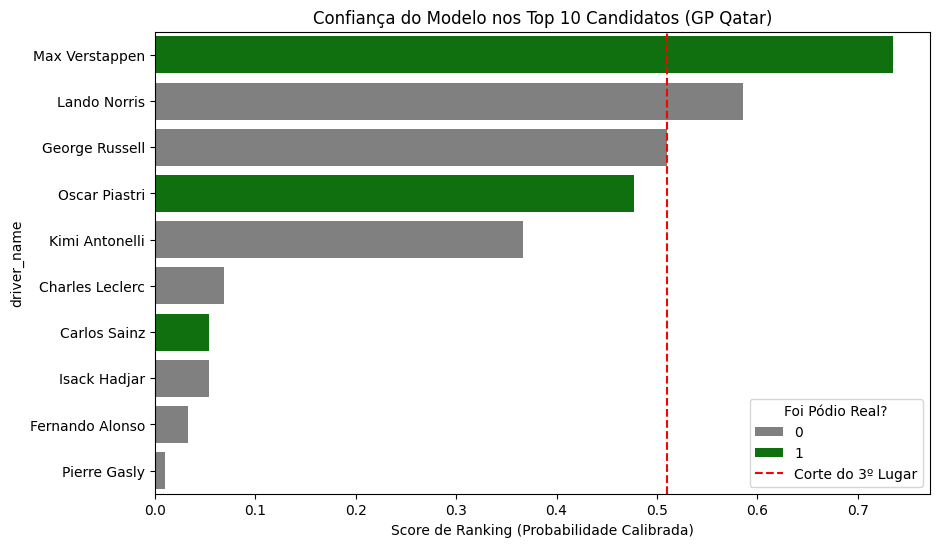

[codecarbon INFO @ 17:22:41] Energy consumed for RAM : 0.016417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:22:41] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 17:22:41] Energy consumed for All CPU : 0.098547 kWh
[codecarbon INFO @ 17:22:41] 0.114964 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:22:56] Energy consumed for RAM : 0.016459 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:22:56] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 17:22:56] Energy consumed for All CPU : 0.098797 kWh
[codecarbon INFO @ 17:22:56] 0.115255 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:23:11] Energy consumed for RAM : 0.016500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 17:23:11] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 17:23:11] Energy consumed for All CPU

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif

# ==========================================
# 1. ENGENHARIA DE MODELO AVANÇADA
# ==========================================
print("--- Treinando Modelo de Ranking Especializado ---")

# Combina dados de treino
X_full_train = pd.concat([X_train, X_test])
y_full_train = pd.concat([y_train, y_test])

base_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(class_weight='balanced', C=0.1, solver='liblinear', max_iter=2000))
])

# Calibração de probabilidade (Isso ajuda muito no ranking)
final_model = CalibratedClassifierCV(base_pipeline, method='isotonic', cv=5)

final_model.fit(X_full_train, y_full_train)
print("Modelo de Ranking treinado com sucesso.")

# ==========================================
# 2. PREDIÇÃO TOP 3 (LÓGICA DE RANKING)
# ==========================================
print(f"\nPrevendo o Grid do GP do Qatar...")

# 1. Calcular apenas as PROBABILIDADES (Scores)
qatar_probs = final_model.predict_proba(X_qatar)[:, 1]

# 2. Criar DataFrame temporário
results = df_qatar_final[['driver_name', 'team_name', 'grid_position']].copy()
results['Real_Podium'] = y_qatar_real.values
results['Score'] = qatar_probs

# 3. A MÁGICA: Ordenar e pegar os Top 3
results = results.sort_values(by='Score', ascending=False)
results['Predicted_Podium'] = 0 # Zera tudo
results.iloc[:3, results.columns.get_loc('Predicted_Podium')] = 1 # Marca os 3 primeiros como 1


conditions = [
    (results['Real_Podium'] == 1) & (results['Predicted_Podium'] == 1),
    (results['Real_Podium'] == 0) & (results['Predicted_Podium'] == 1),
    (results['Real_Podium'] == 1) & (results['Predicted_Podium'] == 0),
    (results['Real_Podium'] == 0) & (results['Predicted_Podium'] == 0)
]
choices = ['ACERTO (Pódio)', 'ERRO (Falso Positivo)', 'ERRO (Perdeu Pódio)', 'Neutro']
results['Status'] = np.select(conditions, choices)

# Estilização da Tabela
def highlight_final(row):
    if row['Status'] == 'ACERTO (Pódio)':
        return ['background-color: #28a745; color: white'] * len(row)
    elif row['Status'] == 'ERRO (Falso Positivo)':
        return ['background-color: #ffc107; color: black'] * len(row) # Amarelo
    elif row['Status'] == 'ERRO (Perdeu Pódio)':
        return ['background-color: #dc3545; color: white'] * len(row) # Vermelho
    elif row['Predicted_Podium'] == 0 and row['Real_Podium'] == 0:
        return ['background-color: #f8f9fa; color: #6c757d'] * len(row) # Cinza suave
    return [''] * len(row)

cols_show = ['driver_name', 'team_name', 'grid_position', 'Score', 'Predicted_Podium', 'Real_Podium', 'Status']

print("\n=== RESULTADO FINAL: TOP 3 PREVISTOS VS REALIDADE ===")
display(results[cols_show].style.apply(highlight_final, axis=1))

# ==========================================
# 4. MÉTRICAS REAIS
# ==========================================
tp = len(results[results['Status'] == 'ACERTO (Pódio)'])
# Como forçamos 3 previsões, a precisão e o recall serão sempre iguais neste cenário específico
# (se acertou 2 de 3 previstos, a precisão é 66% e o recall é 66% de 3 reais)
metric = tp / 3.0 

print(f"\n--- Métricas Ajustadas (Top 3 Fixo) ---")
print(f"Pódios Corretos: {tp}/3")
print(f"Precisão/Recall do Top 3: {metric:.1%}")

if tp == 3:
    print("🏆 GABARITOU! O modelo acertou exatamente o pódio.")
elif tp == 2:
    print("🥈 ÓTIMO! Acertou 2 de 3 (Provavelmente trocou o 3º lugar por uma 'zebra').")
elif tp == 1:
    print("🥉 OK. Acertou o vencedor ou um favorito, mas errou o resto.")
else:
    print("❌ RUIM. O modelo não entendeu a corrida.")

plt.figure(figsize=(10, 6))
top_10 = results.head(10)
sns.barplot(x='Score', y='driver_name', data=top_10, hue='Real_Podium', dodge=False, palette={0:'gray', 1:'green'})
plt.title('Confiança do Modelo nos Top 10 Candidatos (GP Qatar)')
plt.axvline(x=top_10.iloc[2]['Score'], color='red', linestyle='--', label='Corte do 3º Lugar')
plt.xlabel('Score de Ranking (Probabilidade Calibrada)')
plt.legend(title='Foi Pódio Real?')
plt.show()

In [ ]:
df_qatar_final

,season,round,event_name,driver_name,team_name,grid_position,podiums_last_5,weighted_avg_pos,team_podium_rate_5,avg_racecraft,reliability_rate,track_avg_pos,podium
2066,2025,23,Qatar Grand Prix,Max Verstappen,Red Bull Racing,3.0,5.0,2.069943,1.0,1.9,0.933333,1.000000,1
2067,2025,23,Qatar Grand Prix,Oscar Piastri,McLaren,1.0,0.0,10.335717,0.8,-2.4,0.866667,2.500000,1
2068,2025,23,Qatar Grand Prix,Carlos Sainz,Williams,7.0,0.0,10.983334,0.0,-1.3,0.533333,11.000000,1
2069,2025,23,Qatar Grand Prix,Lando Norris,McLaren,2.0,4.0,7.912271,0.8,-3.1,0.800000,7.333333,0
2070,2025,23,Qatar Grand Prix,Kimi Antonelli,Mercedes,5.0,2.0,5.215523,0.8,0.7,0.666667,5.215523,0
2071,2025,23,Qatar Grand Prix,George Russell,Mercedes,4.0,2.0,3.755415,0.8,0.5,0.933333,8.333333,0
2072,2025,23,Qatar Grand Prix,Fernando Alonso,Aston Martin,8.0,0.0,12.638986,0.0,-1.8,0.733333,5.333333,0
2073,2025,23,Qatar Grand Prix,Charles Leclerc,Ferrari,10.0,2.0,7.630187,0.4,-2.5,0.866667,5.000000,0
2074,2025,23,Qatar Grand Prix,Liam Lawson,Racing Bulls,12.0,0.0,12.539320,0.0,-1.5,0.600000,14.000000,0
2075,2025,23,Qatar Grand Prix,Yuki Tsunoda,Red Bull Racing,15.0,0.0,12.289961,1.0,1.0,0.600000,13.666667,0


[codecarbon INFO @ 02:03:57] Energy consumed for RAM : 0.103290 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:03:57] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 02:03:57] Energy consumed for All CPU : 0.619822 kWh
[codecarbon INFO @ 02:03:57] 0.723112 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:04:12] Energy consumed for RAM : 0.103332 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:04:12] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 02:04:12] Energy consumed for All CPU : 0.620072 kWh
[codecarbon INFO @ 02:04:12] 0.723404 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 09:23:36] Background scheduler didn't run for a long period (26366s), results might be inaccurate
[codecarbon INFO @ 09:23:36] Energy consumed for RAM : 0.176571 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 09:23:36] Delta energ

In [ ]:
PALETA = {
    "olivewood": "#210706",
    "tuscan_red": "#891D1A",
    "slate_blue": "#5E657B",
    "creamy_biscotti": "#Fff"
}


plt.rcParams['axes.facecolor']   = PALETA["creamy_biscotti"]
plt.rcParams['figure.facecolor'] = PALETA["creamy_biscotti"]
plt.rcParams['xtick.color']      = PALETA["olivewood"]
plt.rcParams['ytick.color']      = PALETA["olivewood"]
plt.rcParams['text.color']       = PALETA["olivewood"]
plt.rcParams['axes.labelcolor']  = PALETA["olivewood"]
plt.rcParams['axes.edgecolor']   = PALETA["olivewood"]



[codecarbon INFO @ 02:02:12] Energy consumed for RAM : 0.102999 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:02:12] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 02:02:12] Energy consumed for All CPU : 0.618071 kWh
[codecarbon INFO @ 02:02:12] 0.721070 kWh of electricity and 0.000000 L of water were used since the beginning.


<Axes: xlabel='Modelo', ylabel='Accuracy'>

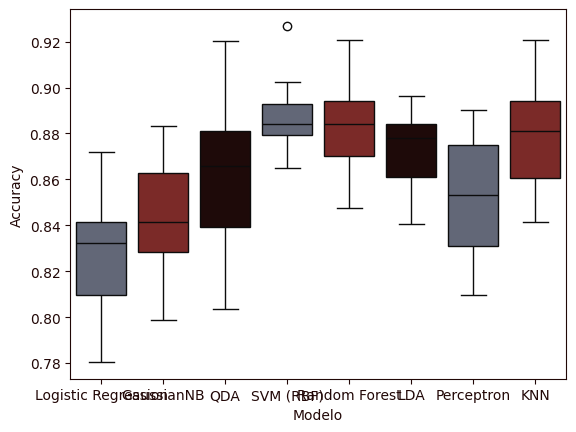

[codecarbon INFO @ 02:02:27] Energy consumed for RAM : 0.103040 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:02:27] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 02:02:27] Energy consumed for All CPU : 0.618321 kWh
[codecarbon INFO @ 02:02:27] 0.721362 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:02:42] Energy consumed for RAM : 0.103082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:02:42] Delta energy consumed for CPU with constant : 0.000250 kWh, power : 60.0 W
[codecarbon INFO @ 02:02:42] Energy consumed for All CPU : 0.618571 kWh
[codecarbon INFO @ 02:02:42] 0.721654 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 02:02:42] 0.001089 g.CO2eq/s mean an estimation of 34.34288261492795 kg.CO2eq/year
[codecarbon INFO @ 02:02:57] Energy consumed for RAM : 0.103124 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 02:02:57] Delta energy consumed for CPU

In [ ]:
sns.boxplot(
    data=df_box,
    x="Modelo",
    y="Accuracy",
    palette=[PALETA["slate_blue"], PALETA["tuscan_red"], PALETA["olivewood"]]
)